# Intro to scattering transform

This notebook shows how to perform the scattering transform of patches of convergence maps.
The scattering transform is a new summary statistic (https://arxiv.org/pdf/2006.08561.pdf) based on iterative smoothing of the field. The smoothing is performed with wavelets - a class of functions that is localised both in real and Fourier space.
As a first step, this notebook shows the types of wavelets will be using and how to smooth a patch.

In [2]:
import pywph as pw
import matplotlib.pyplot as plt
import numpy as np
import pickle
import healpy as hp
def save_obj(name, obj):
    with open(name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, protocol=2)
        f.close()

def load_obj(name):
    with open(name + '.pkl', 'rb') as f:
        mute =  pickle.load(f)
        f.close()
    return mute


# plotting filters

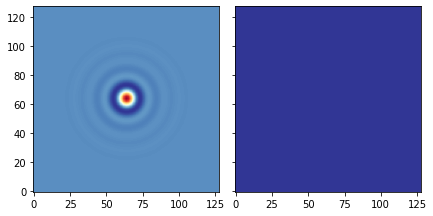

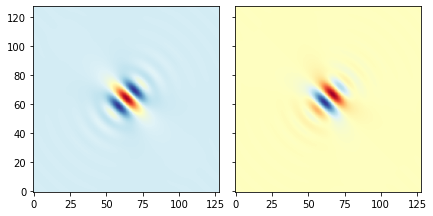

In [3]:
# number of piels per side. ~64/128 are good numbers here.
M, N = 128, 128

# this number identifies the size of the filter. The typical oscillation of the filter is of the order of 2^(j+1) +
# pixels, so there's a limited number of filters you can use based on the patch size.
j=3
# do not change this - this parameter is degenerate with the filter size j.
k0 = 0.85 * np.pi

# let us generate an isotropic wavelet filter. This filter will only have a ``real'' component.
theta = 0.
w = pw.BumpIsotropicWavelet(M, N, j, theta, k0=k0)
g = pw.GaussianFilter(M, N, j)

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
axs[0].imshow(np.fft.fftshift(w.data.real), origin='lower',cmap='RdYlBu_r')
axs[1].imshow(np.fft.fftshift(w.data.imag), origin='lower',cmap='RdYlBu_r')
fig.subplots_adjust(top=0.95, bottom=0.091, left=0.056, right=0.97, hspace=0.19, wspace=0.046)
fig.show()

# let us now generate a directional complex filter.
theta = 2.*np.pi / 8 
# the above choice means we divided 2pi into 8 parts, and we took the angle 2*pi * (2/8). you can change this numnber!
w = pw.BumpSteerableWavelet(M, N, j, theta, k0=k0)
g = pw.GaussianFilter(M, N, j)

fig, axs = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
axs[0].imshow(np.fft.fftshift(w.data.real), origin='lower',cmap = 'RdYlBu_r')
axs[1].imshow(np.fft.fftshift(w.data.imag), origin='lower',cmap = 'RdYlBu_r')
fig.subplots_adjust(top=0.95, bottom=0.091, left=0.056, right=0.97, hspace=0.19, wspace=0.046)
fig.show()


# convolving the field

In [7]:
#let's load a full sky, noiseless convergence map. This comes in the HEALPY format
m_ = np.load('data/map_512_test.npy',allow_pickle=True)

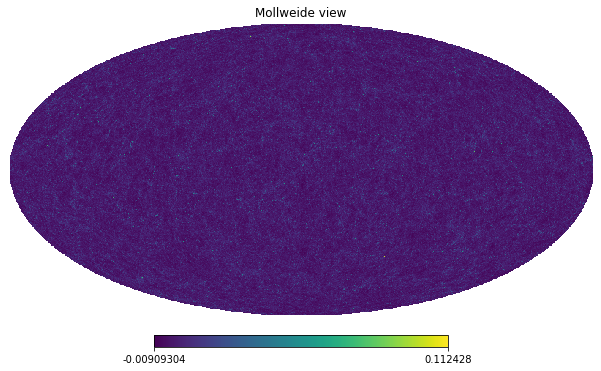

number of pixels:  3145728
pixel resolution [arcmin]:  6.870972823634812


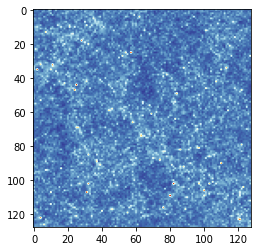

In [8]:
# let's plot it
hp.mollview(m_)
plt.show()
# this map is at resolution nside=512, which means there are
print ('number of pixels: ',hp.pixelfunc.nside2npix(512))
# and that the resolution is
print ('pixel resolution [arcmin]: ',hp.pixelfunc.nside2resol(512,arcmin=True))


# Our wavelet filters are not defined on a sphere, but only on 2D patches.
# We can project part of the spherical map into 2D patches as follows:

# this projects a patch around (ra=0,dec=0) of 128x128 pixels. The new pixel resolution is 20 arcminutes.
# chosing a new pixel resolution that is larger than the native resolution of the healpy map makes sense.
m_ref = hp.gnomview(m_, rot=(0,0), xsize=128 ,no_plot=True,reso=20.,return_projected_map=True)
#m_ref[m_ref>0.01] = 0.01

plt.imshow(m_ref.real,cmap = 'RdYlBu_r')
plt.show()


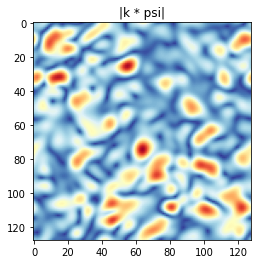

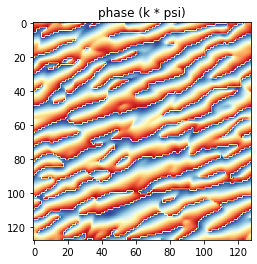

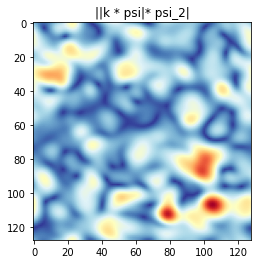

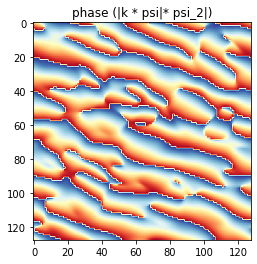

S2:  2.015505456633232e-05


In [9]:
# let us convolve the patch with our filters.

j = 2
theta = 3.*np.pi / 8
k0 = 0.85 * np.pi

# convolution number 1
w = pw.BumpSteerableWavelet(M, N, j, theta, k0=k0)
m = np.fft.ifft2(np.fft.fft2(m_ref)*np.fft.fft2(w.data))
plt.imshow(np.abs(m),cmap = 'RdYlBu_r')
plt.title('|k * psi|')
plt.show()

plt.imshow(np.angle(m),cmap = 'RdYlBu_r')
plt.title('phase (k * psi)')
plt.show()







# convolution number 2
# let's use a differnt orientation; let's smooth |k * psi|.
theta = 5.*np.pi / 8
k0 = 0.85 * np.pi

w = pw.BumpSteerableWavelet(M, N, j, theta, k0=k0)
m = np.fft.ifft2(np.fft.fft2(np.abs(m))*np.conj(np.fft.fft2(w.data)))


plt.imshow(np.abs(m),cmap = 'RdYlBu_r')
plt.title('||k * psi|* psi_2|')
plt.show()

plt.imshow(np.angle(m),cmap = 'RdYlBu_r')
plt.title('phase (|k * psi|* psi_2|)')
plt.show()


    
# compute ``scattering transform'' statistic ``S2'':
print ('S2: ', np.mean(np.abs(m)))
    

Now, let's compute S1 & S2 for different smoothing sizes. We generally follow the definitions here https://arxiv.org/pdf/2006.08561.pdf , although you can notice that different papers use slightly different incrations of the scattering transform. We also introduce an exponent 'q' following https://arxiv.org/pdf/2108.07821.pdf

In [10]:
q1 = 0.8
j = np.arange(0,5)
angles = 8

S1 = np.zeros(len(j))
S2 = np.zeros((len(j),len(j)))

def convolve_field(field,j,theta,M,N,k0):
    w = pw.BumpSteerableWavelet(M, N, j, theta, k0=k0)
    m = np.fft.ifft2(np.fft.fft2(field)*np.fft.fft2(w.data))
    return m

for j_ in j:
    l_ = np.arange(angles)*np.pi / angles
    S1[j_] = np.mean([np.mean(np.abs(convolve_field(m_ref,j_,l,M,N,k0))**q1) for l in l_])
        
        
for j_1 in j:
    for j_2 in j:
        l_ = np.arange(angles)*np.pi / angles
        S2[j_1,j_2] = np.mean([[np.mean(np.abs(convolve_field((np.abs(convolve_field(m_ref,j_1,l1,M,N,k0))),j_2,l2,M,N,k0))**q1) for l1 in l_]for l2 in l_])
       


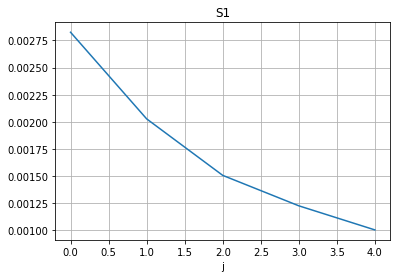

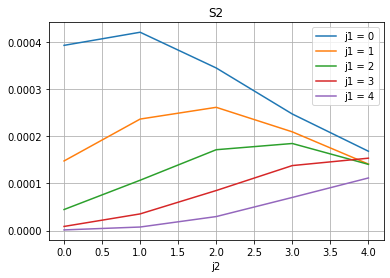

In [11]:
plt.plot(S1)
plt.title('S1')
plt.xlabel('j')
plt.grid()
plt.show()
for j_ in j:
    plt.plot(S2[j_,:],label='j1 = '+str(j_))
plt.xlabel('j2')
plt.title('S2')
plt.legend()
plt.grid()